# FaIR Hist
## Goal: create an accurate temperature hindcast using historical GHG concentrations
- 1750 to 2022
- Start with FaIR calibration data
- Can also test PRIMAP-hist
- Note: this notebook does not incorporate a perturbed parameter ensemble (PPE); it is solely meant for learning how to input historical data
### Erica Simon, 01/22/24
Smith, C. (2023). FaIR calibration data (1.3.1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.10208609

Link to data: https://github.com/chrisroadmap/fair-calibrate/blob/main/data/concentrations/ghg_concentrations_1750-2022.csv

In [357]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

## Create instance

In [358]:
f = FAIR()

In [359]:
f.define_time(1850, 2022, 1)

In [360]:
scenarios = ['s1']
f.define_scenarios(scenarios)

## Define configs

In [361]:
f.define_configs(['c1'])

## Define species and properties

In [362]:
df_conc = pd.read_csv('ghg_concentrations_1750-2022.csv', index_col=0)

In [363]:
species, properties = read_properties(filename='~/examples/species_configs_properties_calibration1.2.0.csv')

In [364]:
for spc in list(properties):
    if spc not in df_conc:
        species.remove(spc)
        properties.pop(spc)
    else:
        # change all to concentration-driven for this datatset
        properties[spc]['input_mode'] = 'concentration'

In [365]:
properties['CO2']['input_mode']

'concentration'

In [366]:
f.define_species(species, properties)

## Data

In [367]:
f.allocate()

## Fill concentrations

In [368]:
# drop the year 1750- not relevant to this analysis
df_conc = df_conc.drop([1750])
df_conc.head()

,CO2,CH4,N2O,HFC-134a,HFC-23,HFC-32,HFC-125,HFC-143a,HFC-152a,HFC-227ea,...,i-C6F14,C7F16,C8F18,CFC-112,CFC-112a,CFC-113a,CFC-114a,HCFC-133a,HCFC-31,HCFC-124
YYYY,,,,,,,,,,,,,,,,,,,,,
1850,285.500000,807.600000,272.100000,0.0,0.0,0.000218,0.0,0.0,0.0,0.000004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1851,285.621912,807.768974,272.181132,0.0,0.0,0.000221,0.0,0.0,0.0,0.000004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1852,285.759838,808.522848,272.262214,0.0,0.0,0.000223,0.0,0.0,0.0,0.000004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1853,285.883757,809.768605,272.365269,0.0,0.0,0.000226,0.0,0.0,0.0,0.000004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1854,285.989701,811.101520,272.471345,0.0,0.0,0.000229,0.0,0.0,0.0,0.000004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [369]:
for column in df_conc:
    # print(column)
    if column in f.species:
        conc = df_conc[column].values.reshape(173, 1)
        fill(f.concentration, conc, scenario='s1', specie=column)

## Fill climate configs

In [370]:
fill(f.climate_configs["ocean_heat_transfer"], [1.1, 1.6, 0.9], config='c1')
fill(f.climate_configs["ocean_heat_capacity"], [8, 14, 100], config='c1')
fill(f.climate_configs["deep_ocean_efficacy"], 1.1, config='c1')

## Fill species configs

In [371]:
f.fill_species_configs()

## Define initial conditions

In [372]:
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)   # f.temperature refers to temperature rise above PI (288 K)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

## Run

In [373]:
f.properties['CO2']

{'type': 'co2',
 'input_mode': 'concentration',
 'greenhouse_gas': True,
 'aerosol_chemistry_from_emissions': False,
 'aerosol_chemistry_from_concentration': False}

In [374]:
f.run()

Running 1 projections in parallel:   0%|          | 0/172 [00:00<?, ?timesteps/s]

## Analyze output

In [402]:
# we want layer 0

f.temperature[dict(layer=0, scenario=0)]

<xarray.DataArray (timebounds: 173, config: 1)>
array([[0.        ],
       [0.01252315],
       [0.02940743],
       [0.04330298],
       [0.05435486],
       [0.06332576],
       [0.07083384],
       [0.07736679],
       [0.08324554],
       [0.08868265],
       [0.09382166],
       [0.09874908],
       [0.10349546],
       [0.10810065],
       [0.11260314],
       [0.11701756],
       [0.12135323],
       [0.12563156],
       [0.12982308],
       [0.13386478],
...
       [1.50435966],
       [1.52674019],
       [1.5489117 ],
       [1.57116159],
       [1.59334863],
       [1.61573069],
       [1.63778093],
       [1.65998767],
       [1.68238007],
       [1.70482533],
       [1.72800898],
       [1.75152642],
       [1.77531796],
       [1.80038477],
       [1.82583274],
       [1.85127948],
       [1.87680536],
       [1.90250518],
       [1.92836612],
       [1.9544699 ]])
Coordinates:
  * timebounds  (timebounds) float64 1.85e+03 1.851e+03 ... 2.021e+03 2.022e+03
    scenario    <U2 's1'
  * config      (config) <U2 'c1'
    layer       int64 0

Text(0.5, 0, 'Year')

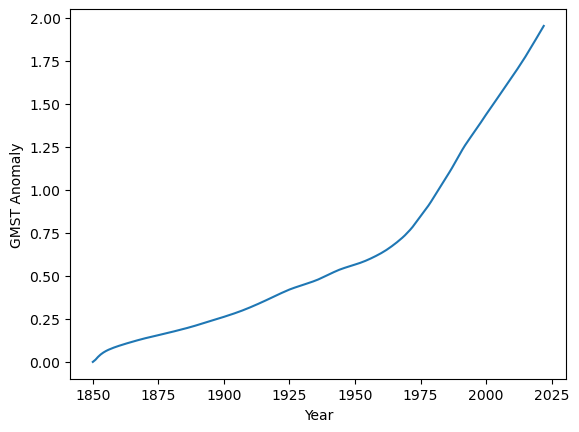

In [410]:
plt.plot(f.timebounds.reshape(173, 1), f.temperature[dict(layer=0, scenario=0)])
plt.ylabel('GMST Anomaly')
plt.xlabel('Year')

The model run does not include solar or volcanic forcing. Importantly, volcanic forcing has a cooling effect, leading to an overestimation in the global temperature anomaly.